# **Stargardt AutoEncoder**

In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

# TensorFlow / Keras imports
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import cifar10

## Data Set

In [2]:
# Load CIFAR-10 dataset (only images, not labels)
(x_train, _), (x_test, _) = cifar10.load_data()

# Normalize pixel values to [0, 1] for neural network
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

print("Train shape:", x_train.shape)   # (50000, 32, 32, 3)
print("Test shape:", x_test.shape)     # (10000, 32, 32, 3)

Train shape: (50000, 32, 32, 3)
Test shape: (10000, 32, 32, 3)


### Simulation Function

In [3]:
def apply_central_mask(img, mask_fraction=0.5, mask_value=0.0):
    """
    Apply a central square mask to an image to simulate a central scotoma
    (like central vision loss in Stargardt's).

    img           : image array of shape (H, W, C) with values in [0, 1]
    mask_fraction : fraction of height/width to cover with the mask (0–1)
    mask_value    : pixel value to fill inside the mask (0.0 = black)
    """
    h, w, c = img.shape
    mh, mw = int(h * mask_fraction), int(w * mask_fraction)

    # Coordinates for the central mask
    y1 = (h - mh) // 2
    y2 = y1 + mh
    x1 = (w - mw) // 2
    x2 = x1 + mw

    masked = img.copy()
    masked[y1:y2, x1:x2, :] = mask_value
    return masked

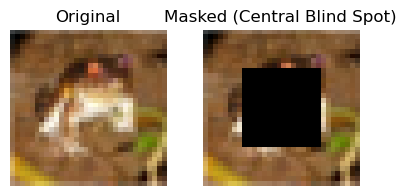

In [4]:
# Test mask on one training image
test_img = x_train[0]
test_masked = apply_central_mask(test_img, mask_fraction=0.5)

plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(test_img)
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Masked (Central Blind Spot)")
plt.imshow(test_masked)
plt.axis("off")

plt.tight_layout()
plt.show()

### Masked Training and Test Set

In [5]:
# Central blind spot to be 0.5
mask_fraction = 0.5  

# Create masked versions of all images
x_train_masked = np.array([
    apply_central_mask(img, mask_fraction=mask_fraction)
    for img in x_train
])

x_test_masked = np.array([
    apply_central_mask(img, mask_fraction=mask_fraction)
    for img in x_test
])

print("Masked train shape:", x_train_masked.shape)
print("Masked test shape:", x_test_masked.shape)

Masked train shape: (50000, 32, 32, 3)
Masked test shape: (10000, 32, 32, 3)


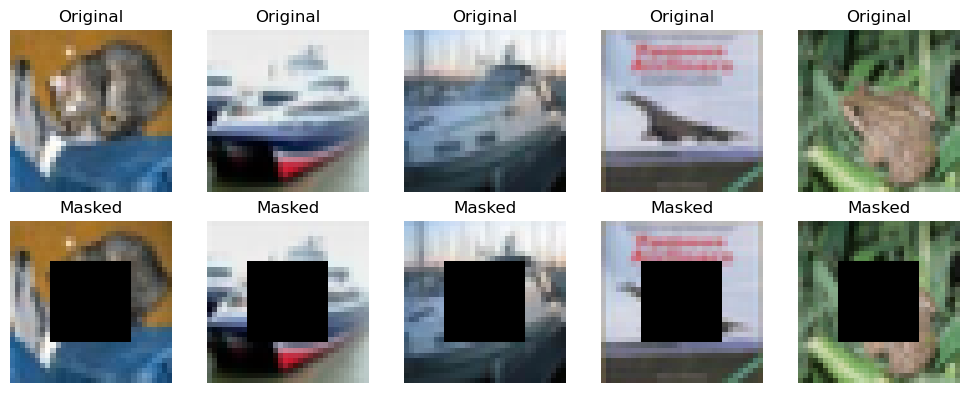

In [6]:
n = 5
plt.figure(figsize=(10, 4))

for i in range(n):
    # Original
    plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("Original")
    plt.axis("off")
    
    # Masked
    plt.subplot(2, n, n + i + 1)
    plt.imshow(x_test_masked[i])
    plt.title("Masked")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Autocoder

### Conventional Autocoder

In [7]:
input_shape = (32, 32, 3)

# Input layer
inputs = layers.Input(shape=input_shape)

# ---------- ENCODER ----------
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)   # -> 16x16x32

x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)   # -> 8x8x64

encoded = layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="encoded")(x)  # -> 8x8x128

# ---------- DECODER ----------
x = layers.UpSampling2D((2, 2))(encoded)             # -> 16x16x128
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)

x = layers.UpSampling2D((2, 2))(x)                   # -> 32x32x64
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(x)

decoded = layers.Conv2D(3, (3, 3), activation="sigmoid", padding="same")(x)

# Build and compile model
autoencoder = models.Model(inputs, decoded)
autoencoder.compile(optimizer="adam", loss="mse")

autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoded (Conv2D)                │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 32, 32, 3)      │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 186,371 (728.01 KB)

 Trainable params: 186,371 (728.01 KB)

 Non-trainable params: 0 (0.00 B)

### Autocoder Train

In [8]:
epochs = 30      # 30 (takes so long to train. maybe just do less)
batch_size = 128

history = autoencoder.fit(
    x_train_masked,   # input: images with central blind spot
    x_train,          # target: original full images
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test_masked, x_test),
)

Epoch 1/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 317s 806ms/step - loss: 0.0161 - val_loss: 0.0109
Epoch 2/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - loss: 0.0104 - val_loss: 0.0105
Epoch 3/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 364s 931ms/step - loss: 0.0097 - val_loss: 0.0094
Epoch 4/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 378s 965ms/step - loss: 0.0093 - val_loss: 0.0091
Epoch 5/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 386s 986ms/step - loss: 0.0090 - val_loss: 0.0096
Epoch 6/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 456s 1s/step - loss: 0.0087 - val_loss: 0.0090
Epoch 7/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 428s 1s/step - loss: 0.0085 - val_loss: 0.0086
Epoch 8/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 385s 983ms/step - loss: 0.0083 - val_loss: 0.0083
Epoch 9/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 3009s 8s/step - loss: 0.0081 - val_loss: 0.0081
Epoch 10/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 454s 1s/step - loss: 0.0080 - val_loss: 0.0080
Epoch 11/30
391/391 ━━━━━━━━━━━━━━━━━━━━ 900s 2s/step - loss: 0.0079 - val_loss: 0.0078
Epoch 12/30
391/391 ━━━━━

## Image Reconstruct

In [9]:
# Use trained autoencoder to reconstruct masked test images
x_test_recon = autoencoder.predict(x_test_masked)

print("Reconstructed test shape:", x_test_recon.shape)

313/313 ━━━━━━━━━━━━━━━━━━━━ 22s 68ms/step
Reconstructed test shape: (10000, 32, 32, 3)


### Visualization

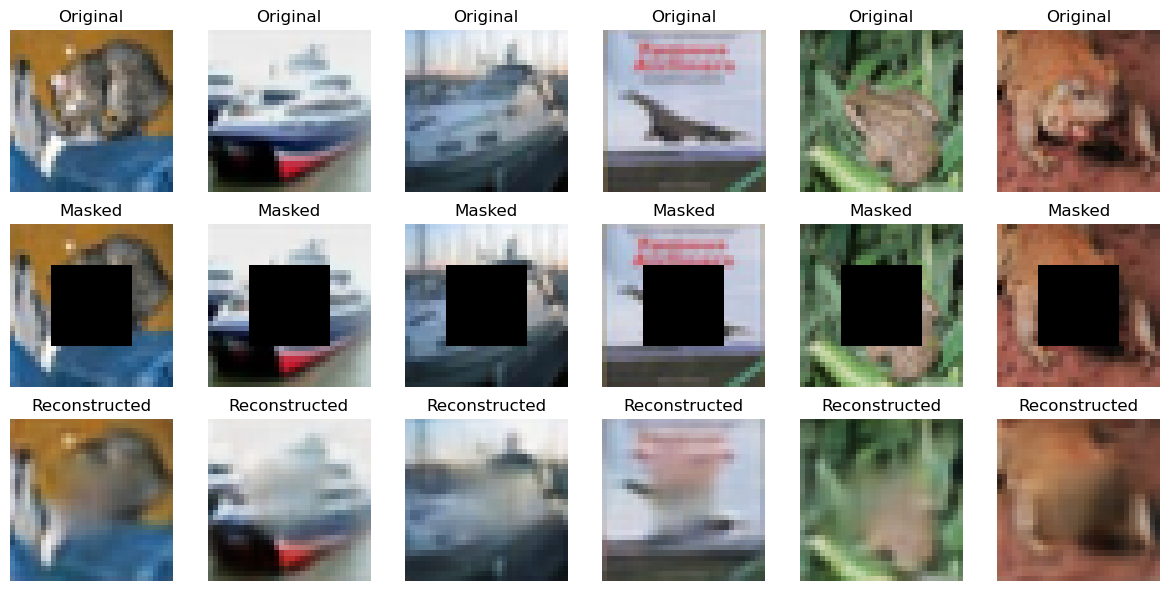

In [10]:
n = 6  # number of examples to display
plt.figure(figsize=(12, 6))

for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i])
    ax.set_title("Original")
    plt.axis("off")
    
    # Masked
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_masked[i])
    ax.set_title("Masked")
    plt.axis("off")
    
    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_recon[i])
    ax.set_title("Reconstructed")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Saved Figure and Model

In [11]:
# Save a sample grid image for project folder
fig = plt.figure(figsize=(12, 6))
n = 6
for i in range(n):
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i]); ax.set_title("Original"); plt.axis("off")
    
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_masked[i]); ax.set_title("Masked"); plt.axis("off")
    
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(x_test_recon[i]); ax.set_title("Reconstructed"); plt.axis("off")

plt.tight_layout()
fig.savefig("stargardt_autoencoder_examples.png", dpi=200)
plt.close(fig)

# Save in recommended Keras format
autoencoder.save("stargardt_autoencoder_model.keras")

# Save legacy HDF5 format as a backup
autoencoder.save("stargardt_autoencoder_model.h5", save_format="h5")